# Сжатие картинок с помощью SVD разложения

В этом задании реализуем сжатие изображения с потерями с помощью SVD разложения. Будем варьировать число сингулярных значений (1, 2, 10, 30, 100) и сравнивать качество и размер.

In [10]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import urllib.request
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

%matplotlib inline

## 1. Загрузка изображения

Картинка скачана!
Размер изображения: (200, 133)


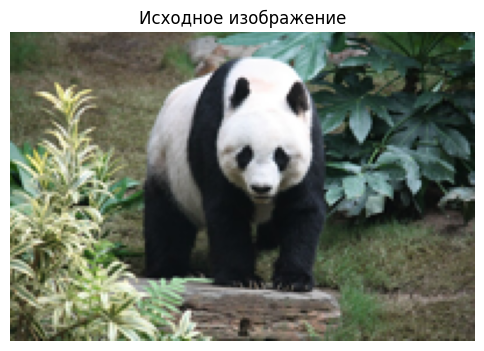

In [11]:
# Скачиваем картинку панды из Wikimedia
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/800px-Grosser_Panda.JPG'
req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
with open('panda.jpg', 'wb') as f:
    f.write(urllib.request.urlopen(req).read())
print('Картинка скачана!')

img = Image.open('panda.jpg')
w, h = img.size
img = img.resize((w // 4, h // 4))  # уменьшаем для скорости

print(f'Размер изображения: {img.size}')
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

## 2. Преобразование в numpy массив

In [12]:
x = np.array(img, dtype=np.float64)
print(f'Shape: {x.shape}, dtype: {x.dtype}')
print(f'Значения от {x.min()} до {x.max()}')

Shape: (133, 200, 3), dtype: float64
Значения от 0.0 до 255.0


## 3. SVD разложение одного канала (демонстрация)

In [13]:
# SVD для красного канала
U, s, Vt = np.linalg.svd(x[:, :, 0], full_matrices=False)
print(f'U: {U.shape}, s: {s.shape}, Vt: {Vt.shape}')

# Проверка: полное восстановление
y = U.dot(np.diag(s).dot(Vt))
print(f'Полное восстановление совпадает: {np.allclose(x[:, :, 0], y)}')

U: (133, 133), s: (133,), Vt: (133, 200)
Полное восстановление совпадает: True


## 4. Функция сжатия изображения

In [14]:
def compress_image_svd(x, r):
    """
    Сжатие изображения с помощью SVD, оставляя r сингулярных значений.
    Применяется к каждому из 3 каналов RGB отдельно.
    """
    x_new = x.copy()
    for i in range(3):
        U, s, Vt = np.linalg.svd(x[:, :, i], full_matrices=False)
        x_new[:, :, i] = U[:, :r].dot(np.diag(s[:r]).dot(Vt[:r]))
    
    x_new = np.clip(x_new, 0, 255)
    x_new = np.asarray(x_new, dtype=np.uint8)
    return x_new

## 5. Сжатие с разным числом сингулярных значений

In [15]:
ranks = [1, 2, 10, 30, 100]
compressed_images = {}

for r in ranks:
    r_actual = min(r, min(x.shape[0], x.shape[1]))
    compressed_images[r] = compress_image_svd(x, r_actual)
    error = np.linalg.norm(x - compressed_images[r].astype(np.float64))
    print(f'r = {r:4d} | Ошибка восстановления (норма Фробениуса): {error:.2f}')

r =    1 | Ошибка восстановления (норма Фробениуса): 14525.49
r =    2 | Ошибка восстановления (норма Фробениуса): 11362.04
r =   10 | Ошибка восстановления (норма Фробениуса): 6608.84
r =   30 | Ошибка восстановления (норма Фробениуса): 3816.95
r =  100 | Ошибка восстановления (норма Фробениуса): 592.28


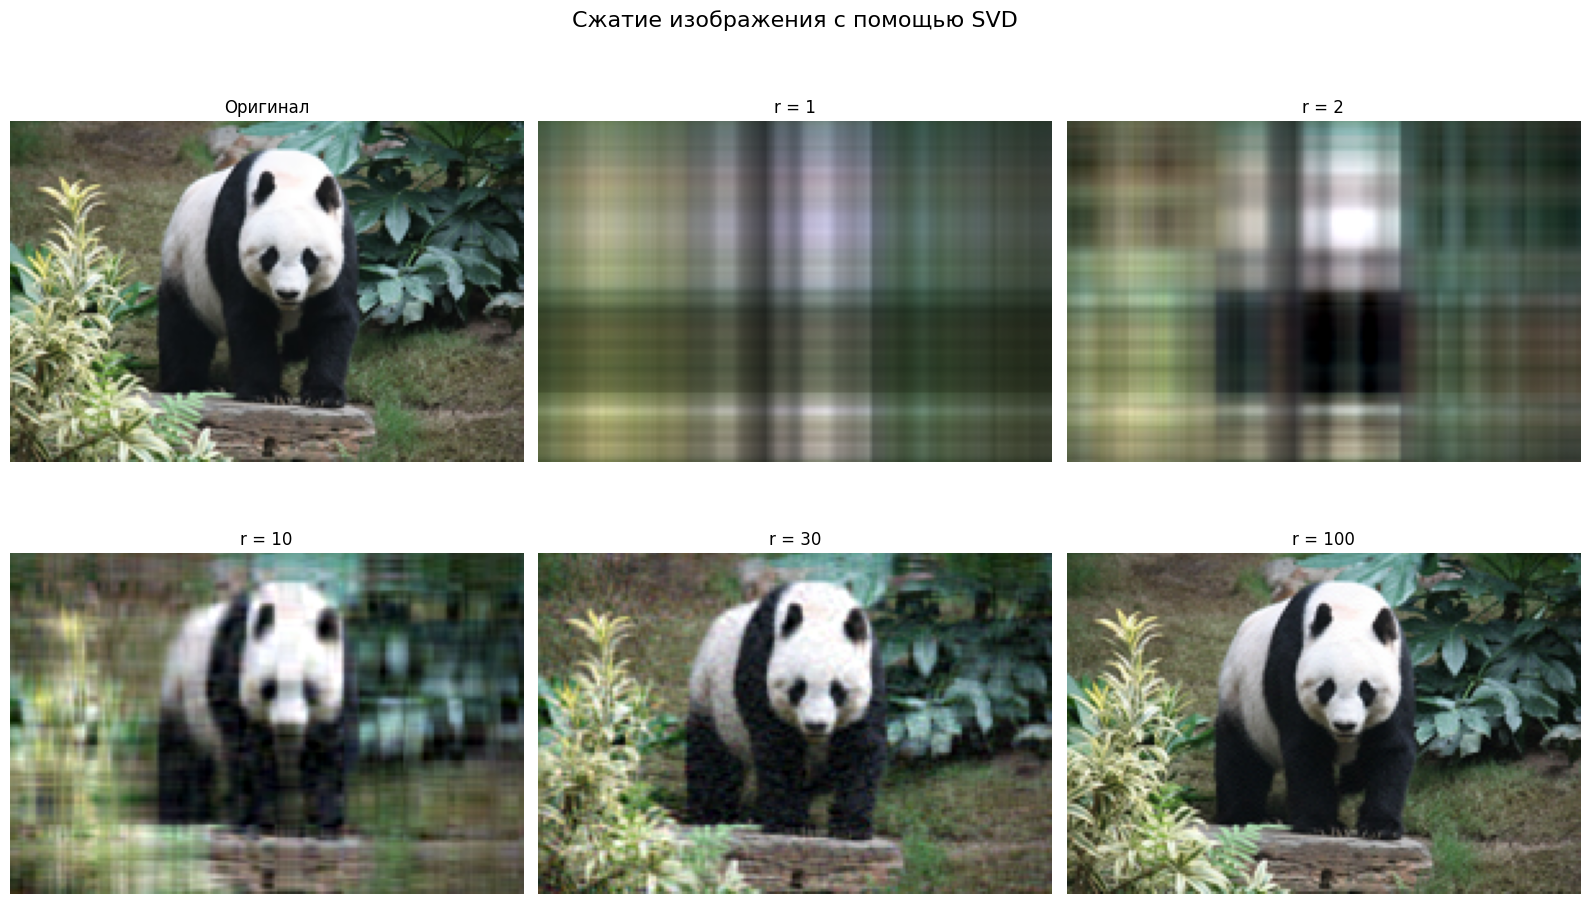

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Исходное изображение
axes[0, 0].imshow(np.asarray(x, dtype=np.uint8))
axes[0, 0].set_title('Оригинал')
axes[0, 0].axis('off')

# Сжатые версии
for idx, r in enumerate(ranks):
    row = (idx + 1) // 3
    col = (idx + 1) % 3
    axes[row, col].imshow(compressed_images[r])
    axes[row, col].set_title(f'r = {r}')
    axes[row, col].axis('off')

plt.suptitle('Сжатие изображения с помощью SVD', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Сравнение размеров (количество байт)

In [17]:
H, W, C = x.shape

# Исходная картинка: H * W * 3 значений (uint8 = 1 байт)
original_size = H * W * C * 1

print(f'Размер изображения: {H} x {W} x {C}')
print(f'Исходный размер (в памяти): {original_size:,} байт ({original_size / 1024:.1f} КБ)')
print()

# SVD хранение на канал: U[:,:r] (H*r) + s[:r] (r) + Vt[:r] (r*W) — float64 = 8 байт
print(f'{"r":>5} | {"SVD размер":>15} | {"Степень сжатия":>15} | {"% от оригинала":>15}')
print('-' * 60)

for r in ranks:
    r_actual = min(r, min(H, W))
    svd_size = C * (H * r_actual + r_actual + r_actual * W) * 8
    ratio = original_size / svd_size
    percent = svd_size / original_size * 100
    print(f'{r:5d} | {svd_size:>12,} Б | {ratio:>14.2f}x | {percent:>14.1f}%')

Размер изображения: 133 x 200 x 3
Исходный размер (в памяти): 79,800 байт (77.9 КБ)

    r |      SVD размер |  Степень сжатия |  % от оригинала
------------------------------------------------------------
    1 |        8,016 Б |           9.96x |           10.0%
    2 |       16,032 Б |           4.98x |           20.1%
   10 |       80,160 Б |           1.00x |          100.5%
   30 |      240,480 Б |           0.33x |          301.4%
  100 |      801,600 Б |           0.10x |         1004.5%


## 7. График сингулярных значений

/var/folders/rp/gk1j_v653yq6xm72l7m8b21m0000gp/T/ipykernel_21213/2789046364.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


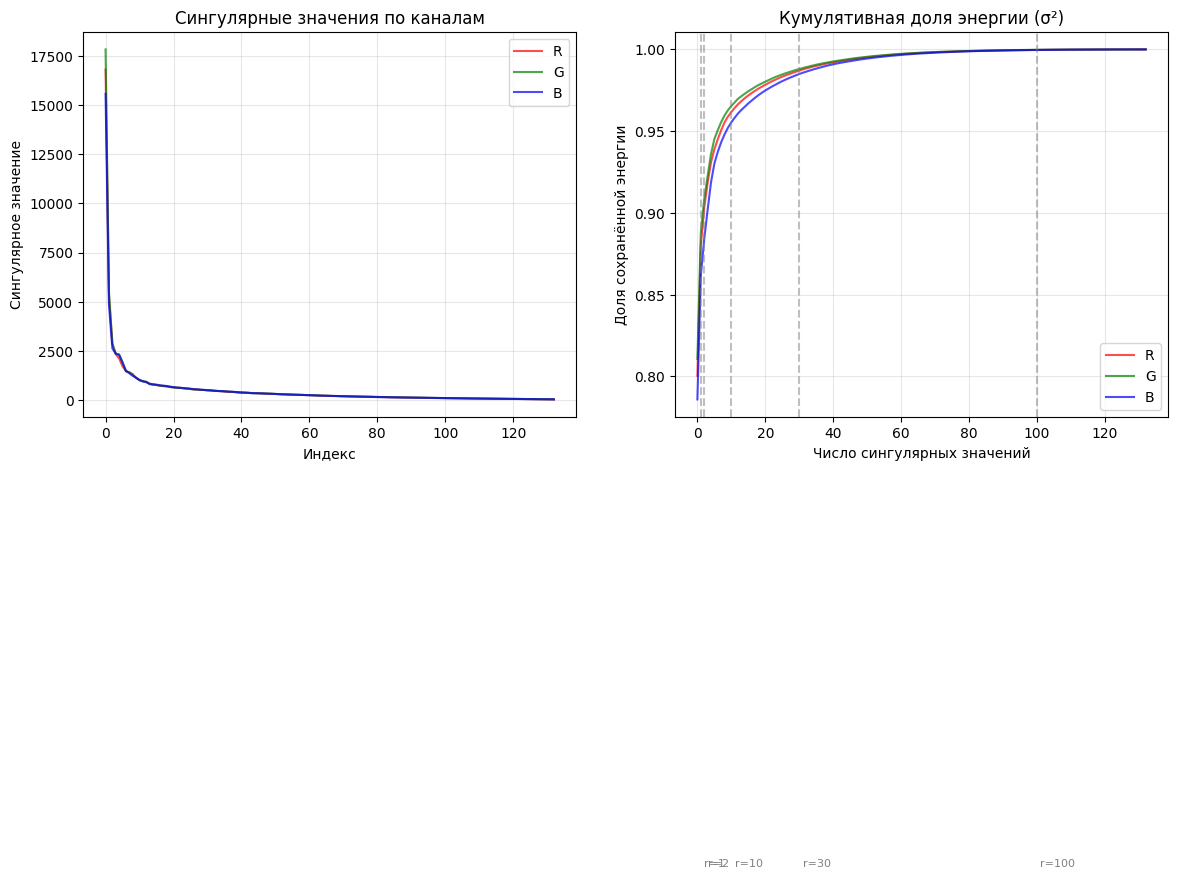

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = ['red', 'green', 'blue']
channel_names = ['R', 'G', 'B']

for i in range(3):
    _, s_ch, _ = np.linalg.svd(x[:, :, i], full_matrices=False)
    ax1.plot(s_ch, color=colors[i], label=channel_names[i], alpha=0.7)
    
    cumsum = np.cumsum(s_ch ** 2) / np.sum(s_ch ** 2)
    ax2.plot(cumsum, color=colors[i], label=channel_names[i], alpha=0.7)

ax1.set_xlabel('Индекс')
ax1.set_ylabel('Сингулярное значение')
ax1.set_title('Сингулярные значения по каналам')
ax1.legend()
ax1.grid(True, alpha=0.3)

for r in ranks:
    ax2.axvline(x=r, color='gray', linestyle='--', alpha=0.5)
    ax2.text(r + 1, 0.5, f'r={r}', fontsize=8, color='gray')

ax2.set_xlabel('Число сингулярных значений')
ax2.set_ylabel('Доля сохранённой энергии')
ax2.set_title('Кумулятивная доля энергии (σ²)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Выводы

1. SVD разложение позволяет эффективно сжимать изображения, оставляя лишь несколько наиболее значимых сингулярных значений.

2. При малом числе сингулярных значений (r=1, 2) картинка сильно размыта и различимы лишь общие контуры. При r=10 уже видны основные формы. При r=30 качество приемлемое, а при r=100 изображение визуально почти неотличимо от оригинала.

3. Сжатие достигается за счёт того, что вместо хранения матрицы H×W мы храним U (H×r), σ (r) и Vt (r×W), что при малых r значительно меньше.

4. Сингулярные значения быстро убывают, поэтому основная «энергия» изображения сосредоточена в первых компонентах — это и делает SVD-сжатие эффективным.